# Zillow Time Series Project

### Importing Necessary Libraries

In [108]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error as mse

In [109]:
df = pd.read_csv('data/zillow_data.csv')

In [110]:
df['Metro'] = df['Metro'].fillna(df['City'])

In [111]:
df.iloc[:,7:].isnull().sum()

1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
1996-08    1039
           ... 
2017-12       0
2018-01       0
2018-02       0
2018-03       0
2018-04       0
Length: 265, dtype: int64

In [112]:
# df.fillna(df.mean(),inplace=True)

In [113]:
df

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14718,58333,1338,Ashfield,MA,Greenfield Town,Franklin,14719,94600.0,94300.0,94000.0,...,216800,217700,218600,218500,218100,216400,213100,209800,209200,209300
14719,59107,3293,Woodstock,NH,Claremont,Grafton,14720,92700.0,92500.0,92400.0,...,202100,208400,212200,215200,214300,213100,213700,218300,222700,225800
14720,75672,40404,Berea,KY,Richmond,Madison,14721,57100.0,57300.0,57500.0,...,121800,122800,124600,126700,128800,130600,131700,132500,133000,133400
14721,93733,81225,Mount Crested Butte,CO,Mount Crested Butte,Gunnison,14722,191100.0,192400.0,193700.0,...,662800,671200,682400,695600,695500,694700,706400,705300,681500,664400


In [114]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [115]:
top_20 = df.SizeRank.quantile(q=0.20)
top_20

2945.4

In [116]:
df_20 = df[df['SizeRank'] < top_20].drop(['RegionID'], axis=1)
print(f'Amount of zipcodes: {len(df_20)}')

Amount of zipcodes: 2945


In [117]:
df_20

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,15217,Pittsburgh,PA,Pittsburgh,Allegheny,2941,105400.0,105600.0,105800.0,105900.0,...,304700,304700,305600,305900,304100,303400,304900,307800,311700,314000
2941,62226,Belleville,IL,St. Louis,Saint Clair,2942,57800.0,58600.0,59300.0,59900.0,...,93200,94900,97000,98500,99100,98900,98700,99500,100900,101900
2942,91350,Santa Clarita,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2943,192600.0,192200.0,191700.0,191300.0,...,543900,549800,555700,560400,564300,568600,573100,576000,577700,578100
2943,60098,Woodstock,IL,Chicago,McHenry,2944,151000.0,150800.0,150400.0,150000.0,...,178900,180300,181200,182200,183800,185200,186400,188500,191800,194200


In [118]:
#Calculate historical return on investment
df_20['ROI']= (df_20['2018-04']/df_20['2008-01'])-1

In [119]:
df_20.sort_values(by='ROI',ascending=False)[['RegionName','2008-01','2018-04','ROI']].head()

,RegionName,2008-01,2018-04,ROI
2452,58801,84700.0,226000,1.668241
1155,11222,661900.0,1721100,1.600242
2580,94043,817000.0,2074900,1.539657
2054,94303,1079200.0,2733900,1.533265
117,11211,645300.0,1623700,1.516194


In [120]:
df_20

,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
0,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,...,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600,0.168878
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,...,310000,312500,314100,315000,316600,318100,319600,321100,321800,0.504441
2,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,...,320600,320200,320400,320800,321200,321200,323000,326900,329900,0.298308
3,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,...,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000,0.123818
4,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,77300.0,...,119400,120000,120300,120300,120300,120300,120500,121000,121500,-0.073933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,15217,Pittsburgh,PA,Pittsburgh,Allegheny,2941,105400.0,105600.0,105800.0,105900.0,...,304700,305600,305900,304100,303400,304900,307800,311700,314000,0.552150
2941,62226,Belleville,IL,St. Louis,Saint Clair,2942,57800.0,58600.0,59300.0,59900.0,...,94900,97000,98500,99100,98900,98700,99500,100900,101900,-0.134240
2942,91350,Santa Clarita,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,2943,192600.0,192200.0,191700.0,191300.0,...,549800,555700,560400,564300,568600,573100,576000,577700,578100,0.168351
2943,60098,Woodstock,IL,Chicago,McHenry,2944,151000.0,150800.0,150400.0,150000.0,...,180300,181200,182200,183800,185200,186400,188500,191800,194200,-0.160761


In [121]:
#Get the 5 zipcodes with highest ROIs within the firms risk profile.
df_top5 = df_20.sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')



 Best 5 Zipcodes:


In [122]:
df_20.columns[6:147]

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08',
       '2007-09', '2007-10', '2007-11', '2007-12'],
      dtype='object', length=141)

In [123]:
df_top5 = df_top.drop(df_20.columns[6:147], axis=1)
df_top5

,RegionName,City,State,Metro,CountyName,SizeRank,2008-01,2008-02,2008-03,2008-04,...,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI
2452,58801,Williston,ND,Williston,Williams,2453,84700.0,85700.0,87400.0,88300.0,...,231800,233400,233100,231600,229500,228100,227500,226800,226000,1.668241
1155,11222,New York,NY,New York,Kings,1156,661900.0,664200.0,666700.0,668100.0,...,1623800,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100,1.600242
2580,94043,Mountain View,CA,San Jose,Santa Clara,2581,817000.0,812500.0,805600.0,797700.0,...,1745300,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900,1.539657
2054,94303,Palo Alto,CA,San Jose,Santa Clara,2055,1079200.0,1088900.0,1099200.0,1109300.0,...,2456800,2522600,2598400,2647600,2657900,2659800,2683900,2718600,2733900,1.533265
117,11211,New York,NY,New York,Kings,118,645300.0,648100.0,651100.0,654800.0,...,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700,1.516194


In [133]:
df_top5_bar = df_top5[['RegionName', 'ROI']]


In [134]:
df_top5_bar.head()

,RegionName,ROI
2452,58801,1.668241
1155,11222,1.600242
2580,94043,1.539657
2054,94303,1.533265
117,11211,1.516194


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'ROI for Top 5 Zipcodes')

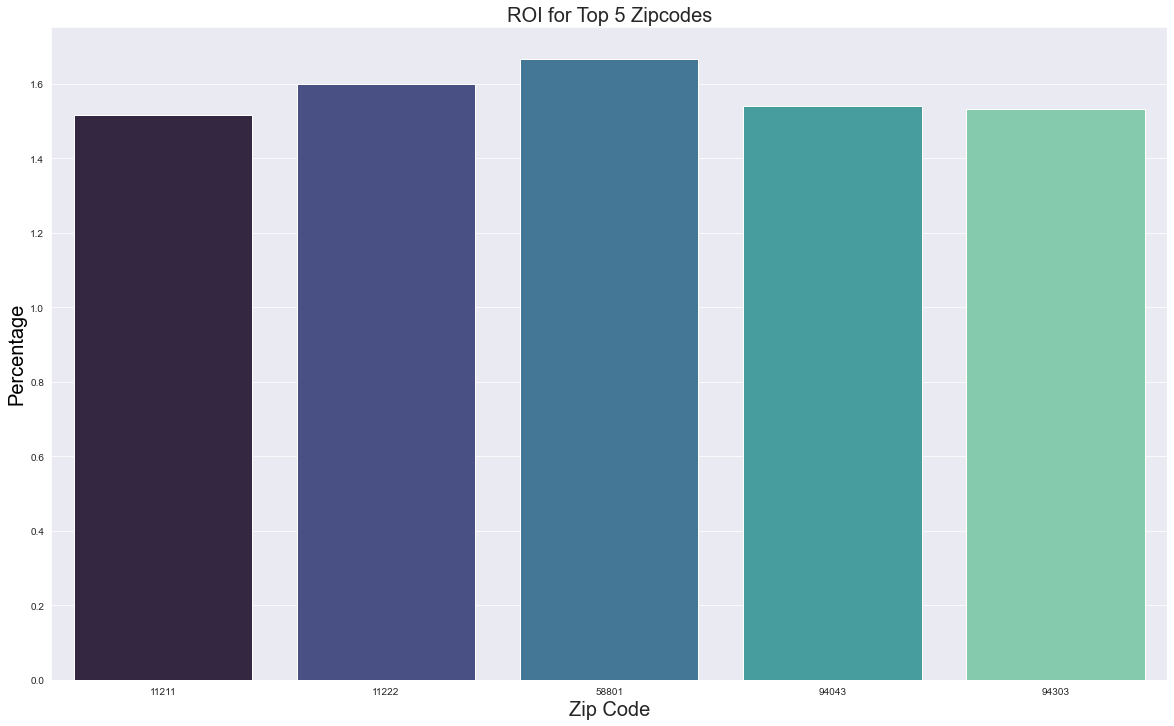

In [141]:
import seaborn as sns

x= df_top5_bar['RegionName']
y= df_top5_bar['ROI']

fig, ax = plt.subplots(figsize=(20,12))
sns.set_style("darkgrid")


ax = sns.barplot(x, y, palette='mako')
ax.set_xlabel('Zip Code', fontsize=20)
ax.set_ylabel('Percentage', color='black', fontsize=20)
ax.set_title('ROI for Top 5 Zipcodes', fontsize=20)



In [107]:
df_top5_bar

,RegionName,Metro,CountyName,SizeRank
2452,58801,Williston,Williams,2453
1155,11222,New York,Kings,1156
2580,94043,San Jose,Santa Clara,2581
2054,94303,San Jose,Santa Clara,2055
117,11211,New York,Kings,118


In [62]:
df_top5 = df_top5.drop(['City','State','Metro', 'CountyName', 'SizeRank', 'ROI'],axis=1)


In [63]:
df_top5

,RegionName,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2452,58801,84700.0,85700.0,87400.0,88300.0,88700.0,88900.0,88900.0,89100.0,89300.0,...,229200,231800,233400,233100,231600,229500,228100,227500,226800,226000
1155,11222,661900.0,664200.0,666700.0,668100.0,665000.0,656200.0,647100.0,640900.0,637900.0,...,1598000,1623800,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100
2580,94043,817000.0,812500.0,805600.0,797700.0,790000.0,783200.0,777800.0,773900.0,770800.0,...,1709400,1745300,1779800,1812000,1847800,1881900,1915700,1965600,2031800,2074900
2054,94303,1079200.0,1088900.0,1099200.0,1109300.0,1116600.0,1119100.0,1116700.0,1111000.0,1104500.0,...,2416900,2456800,2522600,2598400,2647600,2657900,2659800,2683900,2718600,2733900
117,11211,645300.0,648100.0,651100.0,654800.0,656400.0,653200.0,649600.0,645900.0,642500.0,...,1405100,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700


In [64]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [65]:
ts_best5 = melt_data(df_top5).set_index('time')
ts_best5

,RegionName,value
time,,
2008-01-01,58801,84700.0
2008-01-01,11222,661900.0
2008-01-01,94043,817000.0
2008-01-01,94303,1079200.0
2008-01-01,11211,645300.0
...,...,...
2018-04-01,58801,226000.0
2018-04-01,11222,1721100.0
2018-04-01,94043,2074900.0


In [66]:
dfs_ts = []
for zc in ts_best5.RegionName.unique():
    #Create separate dataframes for each zipcode with a monthly frequency.
    new_df = ts_best5[ts_best5['RegionName']==zc].asfreq('MS')
    dfs_ts.append(new_df)

In [67]:
print('Time series data for the 5 zipcodes:\n',ts_best5.head())

Time series data for the 5 zipcodes:
             RegionName      value
time                             
2008-01-01       58801    84700.0
2008-01-01       11222   661900.0
2008-01-01       94043   817000.0
2008-01-01       94303  1079200.0
2008-01-01       11211   645300.0


In [68]:
dfs_ts[0]

,RegionName,value
time,,
2008-01-01,58801,84700.0
2008-02-01,58801,85700.0
2008-03-01,58801,87400.0
2008-04-01,58801,88300.0
2008-05-01,58801,88700.0
...,...,...
2017-12-01,58801,229500.0
2018-01-01,58801,228100.0
2018-02-01,58801,227500.0


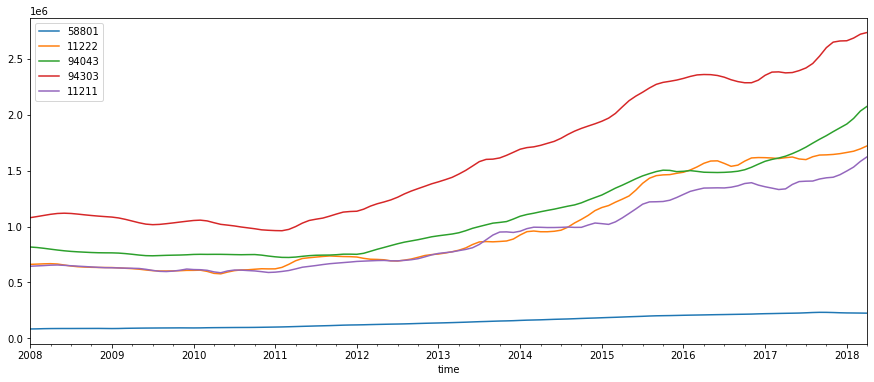

In [69]:
for i in range(5):
    dfs_ts[i].value.plot(label=dfs_ts[i].RegionName[0],figsize=(15,6))
    plt.legend();

In [70]:
#Calculate monthly returns in new column 'ret' for each zipcode.
for zc in range(len(dfs_ts)):
    dfs_ts[zc]['monthly_return']=np.nan*len(dfs_ts[zc])
    for i in range(len(dfs_ts[zc])-1):
        dfs_ts[zc]['monthly_return'][i+1]= (dfs_ts[zc].value.iloc[i+1] / dfs_ts[zc].value.iloc[i]) - 1        

<ipython-input-70-77ae08bcfaba>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_ts[zc]['monthly_return'][i+1]= (dfs_ts[zc].value.iloc[i+1] / dfs_ts[zc].value.iloc[i]) - 1


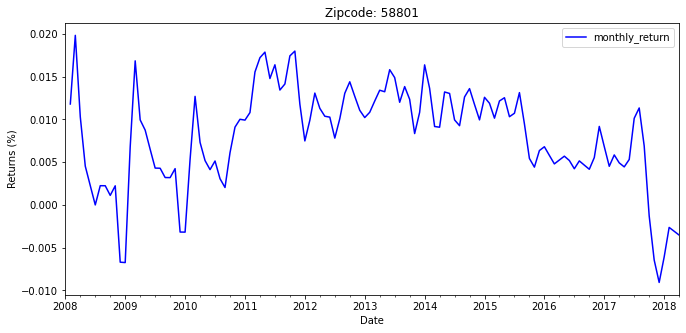

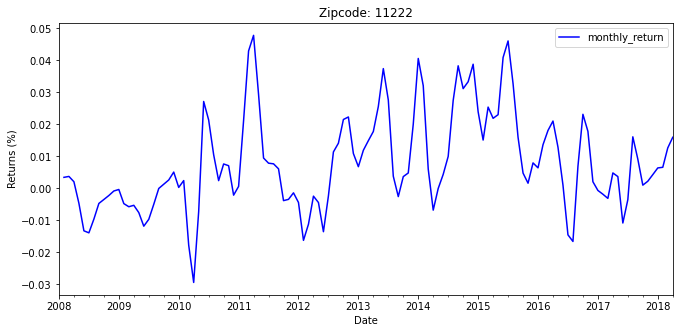

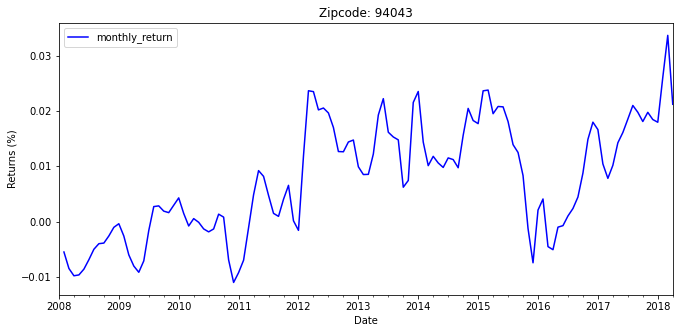

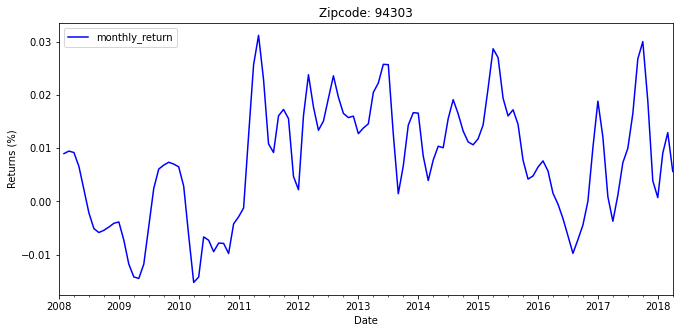

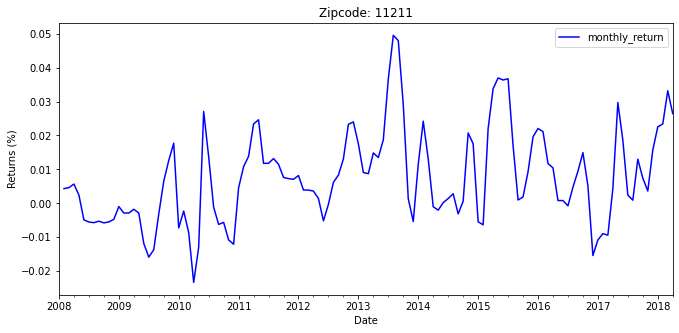

In [71]:
#Plot the monthly returns of each zipcode
for i in range(len(dfs_ts)):
    dfs_ts[i].monthly_return.plot(figsize=(11,5), color = 'b')
    plt.title(f'Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.xlabel('Date')
    plt.ylabel('Returns (%)')
    plt.legend(loc='best')
    plt.show()

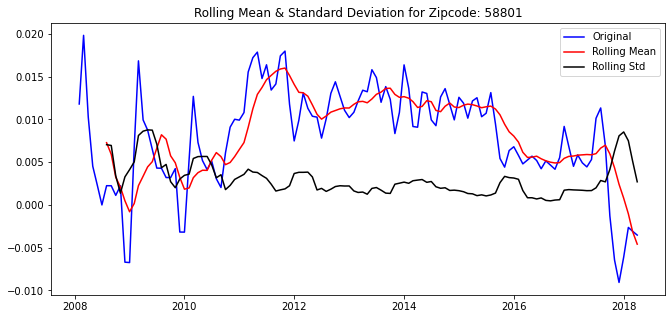

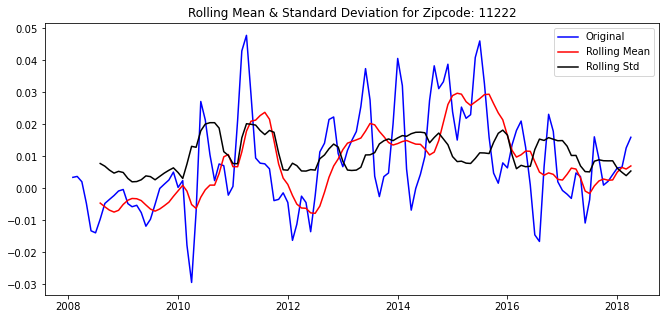

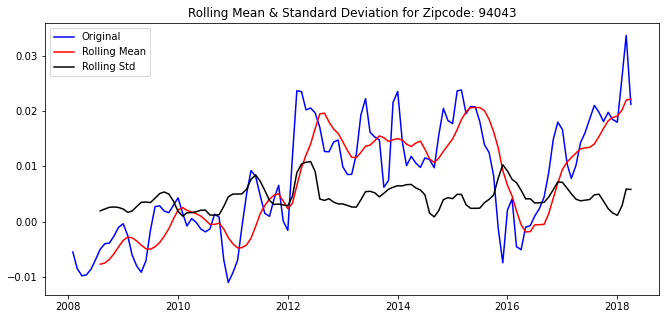

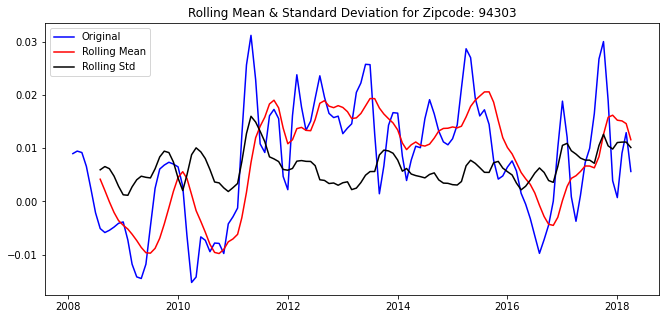

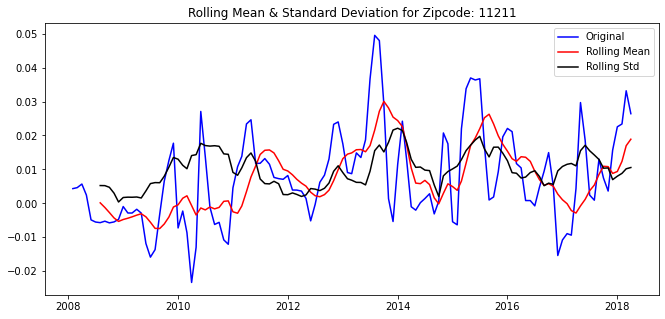

In [72]:
for i in range(len(dfs_ts)):
    rolmean = dfs_ts[i].monthly_return.rolling(window = 7, center = False).mean()
    rolstd = dfs_ts[i].monthly_return.rolling(window = 7, center = False).std()
    fig = plt.figure(figsize=(11,5))
    orig = plt.plot(dfs_ts[i].monthly_return, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for Zipcode: {dfs_ts[i].RegionName[0]}')
    plt.show()

In [73]:
for i in range(5):
    results = adfuller(dfs_ts[i].monthly_return.dropna())
    print(f'ADFuller test p-value for zipcode: {dfs_ts[i].RegionName[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 58801
p-value: 0.7355011115703788
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 11222
p-value: 0.05082104324899229
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 94043
p-value: 0.47058922329163255
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 94303
p-value: 0.11297252916273193
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 11211
p-value: 0.06662411687125772
Fail to reject the null hypothesis. Data is not stationary.



In [74]:
ts_58801 = dfs_ts[0].monthly_return.diff().dropna()
ts_11222 = dfs_ts[1].monthly_return.diff().dropna()
ts_94043 = dfs_ts[2].monthly_return.diff().dropna()
ts_94303 = dfs_ts[3].monthly_return.diff().dropna()
ts_11211 = dfs_ts[4].monthly_return.diff().dropna()


In [75]:
def cutoff(df):
    ct = round(df.shape[0]*0.8)
    return ct
    
#def train_test(df):
    cutoff = round(df.shape[0]*0.8)
    train = df[:cutoff]
    test = df[cutoff:]
    return train, test

def acf_pacf(df):
    #Create figure
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    #Make ACF plot
    plot_acf(df, ax=ax1)
    #Make PACF plot
    plot_pacf(df, ax=ax2)
    plt.show();

In [76]:
def model_fit(df,pdq=(1,0,1),pdqs=(0,0,0,1)):
    train, test = train_test(df)
    model = SARIMAX(train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return train, test, results

In [77]:
def test_RMSE(df,pdq=(1,0,1),pdqs=(0,0,0,1), display=True):
    X = df.values
    train, test = X[:-36],X[-36:]
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = SARIMAX(history, order=pdq,seasonal_order=pdqs)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-36:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

In [78]:
def train_RMSE(train, results, display = True):
    train_pred = results.predict(-36)
    rmse = sqrt(MSE(train[-36:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[-60:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predicted Returns')
        plt.show()

In [31]:
# def model_fit(df, train, pdq=(1,0,1)):
#     model = SARIMAX(train, order=pdq)
#     results = model.fit()
#     results.summary
#     residuals = results.resid
#     print(results.summary())
#     results.plot_diagnostics(figsize=(11,8))
#     plt.show();
#     return results

In [33]:
# def model_fit(df, test, pdq=(1,0,1)):
#     model = SARIMAX(test, order=pdq)
#     results = model.fit()
#     results.summary
#     residuals = results.resid
#     print(results.summary())
#     results.plot_diagnostics(figsize=(11,8))
#     plt.show();
#     return results

In [34]:
# def test_RMSE(df, pdq=(1,0,1), display=True):
#     model = SARIMAX(df, order=pdq)
#     test_result = model.fit()
#     test_pred = test_result.predict(typ='levels')
#     rmse = np.sqrt(mse(df, test_pred))
#     print(f'SARIMA model RMSE on train data: %.5f' % rmse)
#     if display:
#         plt.figure(figsize=(13,6))
#         test[-60:].plot(label='Actual',color='b')
#         test_pred.plot(label='Predicted',color='r')
#         plt.legend(loc='best')
#         plt.title('Actual Test Data vs. Predicted Returns')
#         plt.show();

In [32]:
# def train_RMSE(df, pdq=(1,0,1), display=True):
#     model = SARIMAX(train, order=pdq)
#     train_result = model.fit()
#     train_pred = train_result.predict(typ='levels')
#     rmse = np.sqrt(mse(df, train_pred))
#     print(f'SARIMA model RMSE on train data: %.5f' % rmse)
#     if display:
#         plt.figure(figsize=(13,6))
#         train[-60:].plot(label='Actual',color='b')
#         train_pred.plot(label='Predicted',color='r')
#         plt.legend(loc='best')
#         plt.title('Actual Train Data vs. Predicted Returns')
#         plt.show();

In [79]:
def forecast_model(df,pdq=(1,0,1),display=True,zc='input zipcode'):
    model = SARIMAX(df, order=pdq)
    model_fit = model.fit()
    output = model_fit.get_prediction(start='2018-04',end='2028-04', dynamic=True)
    forecast_ci = output.conf_int()
    if display:
        fig, ax = plt.subplots(figsize=(13,6))
        output.predicted_mean.plot(label='Forecast')
        ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
        plt.title('Forecast of Monthly Returns')
        plt.xlabel('Time')
        plt.legend(loc='best')
        plt.show()
    year_1= (1+output.predicted_mean[:12]).prod()-1
    year_3=(1+output.predicted_mean[:36]).prod()-1
    year_5= (1+output.predicted_mean[:60]).prod()-1
    year_10=(1+output.predicted_mean).prod()-1
    print(f'Total expected return in 1 year: {round(year_1*100,2)}%')
    print(f'Total expected return in 3 years: {round(year_3*100,2)}%')
    print(f'Total expected return in 5 year: {round(year_5*100,2)}%')
    print(f'Total expected return in 10 years: {round(year_10*100,2)}%')
    tot_ret = [zc,year_1,year_3,year_5,year_10]
    return tot_ret

In [80]:
ct = cutoff(ts_58801)
ct

98

In [81]:
train_58801 = ts_58801[:ct]
test_58801 = ts_58801[ct:]

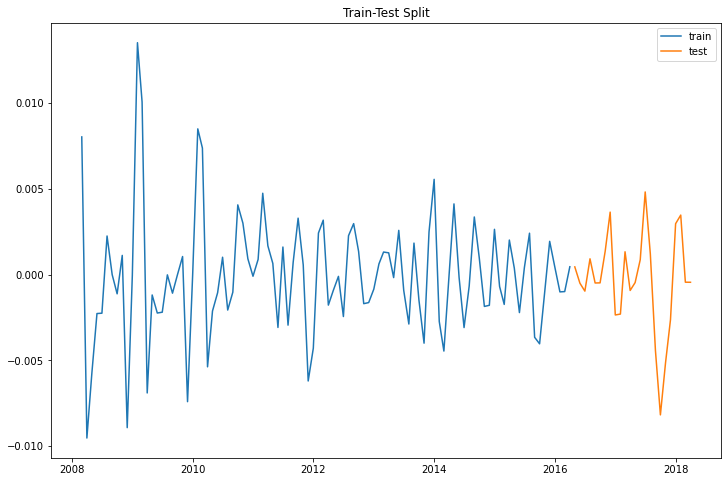

In [82]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train_58801, label='train')
ax.plot(test_58801, label='test')
ax.set_title('Train-Test Split');
plt.legend()
plt.show();

NameError: name 'plot_acf' is not defined

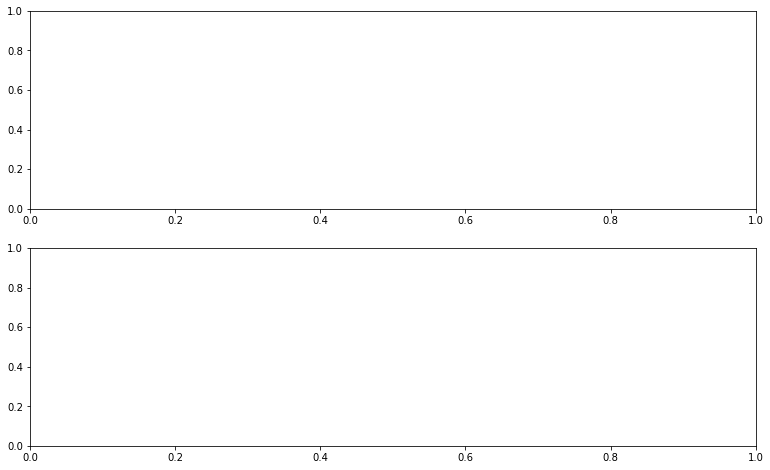

In [83]:
acf_pacf(ts_58801)

In [84]:
results_58801 = pm.auto_arima(ts_58801,information_criterion='aic',m=12,d=0,
                        start_p=1,start_q=1, max_p=3, max_q=3,
                        stepwise=True,trace=True,error_action='ignore',suppress_warnings=True)
results_58801

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-1068.658, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-1032.786, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1061.767, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-1064.476, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-1034.624, Time=0.02 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-1064.188, Time=0.41 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-1074.002, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-1044.493, Time=0.17 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-1072.358, Time=1.06 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-1070.572, Time=1.34 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-1073.844, Time=0.26 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=-1085.920, Time=0.36 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-1062.230, Time=0.09 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=-1084.550, Time=1.18 sec
 ARIM

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(1, 0, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [86]:
model_fit(train_58801, ts_58801[:ct], pdq=(1,0,1))

NameError: name 'train_test' is not defined

In [ ]:
train_RMSE(train_58801, pdq=(1,0,1))

In [ ]:
model_fit(test_58801, ts_58801[ct:], pdq=(1,0,1))

In [ ]:
test_RMSE(test_58801, pdq=(1,0,1))

In [ ]:
forecast_model(ts_58801, pdq=(1,0,1), zc=58801)